In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import tools

# the autoreload magic command above makes changes to dev functions put in tools.py 
# immmidiately available in the notebook without restarting the kernel.

# relevant functions put in tools.py can be transferred to a common or upstream library 
# later on during the hackweek.

## AWS DEM data access

Data access to historical and modern DEMs produced over Easton Glacier at Mount Baker and South Cascade Glacier in the northern Cascade Range. All DEMs are coregistered to a modern reference DEM, projected on to a common grid, and stacked using the Geospatial Time Series Analaysis ([GTSA](https://github.com/friedrichknuth/gtsa/tree/main)) library.

**Mount Baker** (1947 - 2020)  
**South Cascade Glacier** (1958 - 2021)

The reference DEM for Mount Baker is dated 2015-08-27 and is included in the stack. This DEM is derived from WADNR lidar and provides full spatial coverage. The reference DEM for South Cascade Glacier is a composite 2013-2015 DEM and is not included in the stack. This DEM was used for coregistration purposes only as it provides greater coverage over stable ground.

In [3]:
baker_url = 's3://petrichor/geosmart/baker.zarr/'
scg_url = 's3://petrichor/geosmart/scg.zarr/'

In [4]:
baker_ds = xr.open_dataset(baker_url, chunks='auto', engine='zarr', storage_options={"anon": True})
scg_ds = xr.open_dataset(scg_url, chunks='auto', engine='zarr', storage_options={"anon": True})

### Dataset overview

In [5]:
baker_ds
# scg_ds

<xarray.Dataset>
Dimensions:      (time: 55, y: 5901, x: 3779)
Coordinates:
  * time         (time) datetime64[ns] 1947-09-14 1950-09-02 ... 2020-12-12
  * x            (x) float64 5.842e+05 5.842e+05 ... 5.879e+05 5.88e+05
  * y            (y) float64 5.403e+06 5.403e+06 ... 5.397e+06 5.397e+06
Data variables:
    band1        (time, y, x) float32 dask.array<chunksize=(55, 843, 540), meta=np.ndarray>
    spatial_ref  int64 ...
Attributes:
    AREA_OR_POINT:  Area
    add_offset:     0.0
    crs:            PROJCS["WGS 84 / UTM zone 10N",GEOGCS["WGS 84",DATUM["WGS...
    scale_factor:   1.0

### Examine spatial and temporal coverage

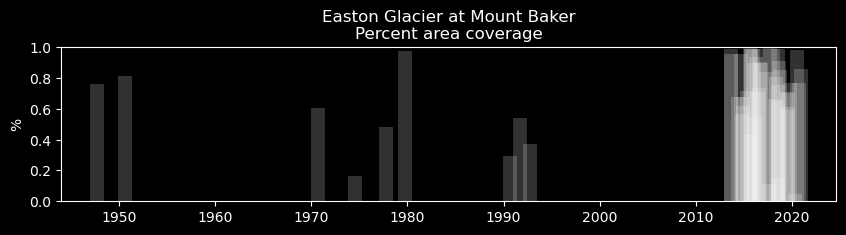

In [6]:
tools.plot_percent_area_coverage(baker_ds, title = 'Easton Glacier at Mount Baker\nPercent area coverage')
# tools.plot_percent_area_coverage(scg_ds, title = 'South Cascade Glacier\nPercent area coverage')

# note that the SCG stack is clipped to the maximum glacier outline which affects percent coverage of total area

### Plot a time stamp 

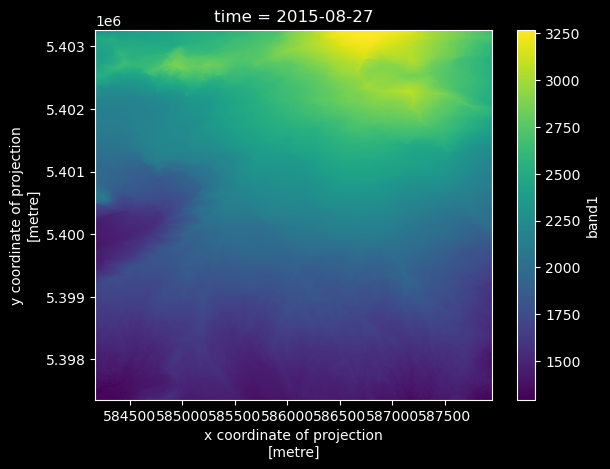

In [7]:
baker_ds['band1'].sel(time='2015-08-27').plot()
# scg_ds['band1'].isel(time=0).plot()

### Plot bounds on interactive map

In [8]:
baker_gdf = tools.bounds2polygon(*baker_ds.rio.bounds(),baker_ds.rio.crs)
baker_gdf.explore(tiles="https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}",
               attr='Google')

# scg_gdf = tools.bounds2polygon(*scg_ds.rio.bounds(),scg_ds.rio.crs)
# scg_gdf.explore(tiles="https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}",
#                attr='Google')

## Additional examples

For examples of computations along the time axis see [examples in GTSA library](https://github.com/friedrichknuth/gtsa/blob/main/notebooks/processing/02_time_series_computations.ipynb).

## References

[Historical HSfM DEMs](https://zenodo.org/records/7297154)

Knuth, Friedrich, David Shean, Shashank Bhushan, Eli Schwat, Oleg Alexandrov, Christopher McNeil, Amaury Dehecq, Caitlyn Florentine, and Shad O’Neel. "Historical Structure from Motion (HSfM): Automated processing of historical aerial photographs for long-term topographic change analysis." Remote Sensing of Environment 285 (2023): 113379.

[USGS Geodetic DEMs](https://alaska.usgs.gov/products/data/glaciers/benchmark_geodetic.php)

McNeil, C.J., Florentine, C.E., Bright, V.A.L., Fahey, M.J., McCann, E., Larsen, C.F., Thoms, E.E., Shean, D.E., McKeon, L.A., March, R.S., Keller, W., Whorton, E.N., O'Neel, S., Baker, E.H., Sass, L.C. and Bollen, K.E. 2019, Geodetic data for USGS benchmark glaciers: orthophotos, digital elevation models, glacier boundaries and surveyed positions (ver 3.0, August 2022): U.S. Geological Survey data release, https://doi.org/10.5066/P9R8BP3K.

[EarthDEM Strips](https://www.pgc.umn.edu/data/earthdem/)

DEM Strips:  Porter, Claire; Howat, Ian; Husby, Erik; Noh, Myoung-Jon; Khuvis, Samuel; Danish, Evan; Tomko, Karen; Gardiner, Judith; Negrete, Adelaide; Yadav, Bidhyananda; Klassen, James; Kelleher, Cole; Cloutier, Michael; Bakker, Jesse; Enos, Jeremy; Arnold, Galen; Bauer, Greg; Morin, Paul, 2022, “EarthDEM – Strips, Version 1”, https://doi.org/10.7910/DVN/LHE9O7, Harvard Dataverse, V1